# Report Analysis
Save figures where possible using ```plt.savefig('image.png')```

Image ideas:
* Accuracy vs Partition number : performance 
* Runtime vs Partition number : speed
* Accuracy vs Runtime : trade-off
* Speed-up : scalability against serial implementation
* Confusion Matrices 
* (potentially Size-up / Scale-up)

Ensure the evaluation metrics identified in lit review reflect this. 

In [124]:
import os
import json
import pandas as pd
import numpy as np

def load_combined_report_dataframe(json_filename="report.json"):
    # Use relative path (assumes same directory)
    json_path = os.path.join(os.getcwd(), json_filename)

    with open(json_path, "r") as f:
        all_reports = json.load(f)

    records = []

    for key, report in all_reports.items():
        try:
            row_data = {}

            # Merge all relevant sections
            row_data.update(report.get("performance", {}))
            row_data.update(report.get("timing", {}))
            row_data.update(report.get("complexity", {}))

            row_data["iteration"] = int(key)  # add the loop index for row label
            records.append(row_data)
        except Exception as e:
            print(f"Error processing report {key}: {e}")

    df = pd.DataFrame(records).set_index("iteration").sort_index()
    return df

df1 = load_combined_report_dataframe('report1.json')
df2 = load_combined_report_dataframe("report2.json")
df3 = load_combined_report_dataframe("report3.json")
df4 = load_combined_report_dataframe("report4.json")


In [125]:
def tot_time_col(df) -> pd.DataFrame:
    df['Total_Time'] = df['Ingestion_time'] + df['Preprocessing train data_time'] + df['Training_time'] + df['Preprocessing test data_time'] + df['Prediction_time']  
    return df

df1 = tot_time_col(df1)
df2 = tot_time_col(df2)
df3 = tot_time_col(df3)
df4 = tot_time_col(df4)

avg = pd.concat([df1, df2, df3, df4]).groupby(level=0).mean()
df_list = [avg, df1, df2, df3, df4]
df_names = ['avg', 'df1', 'df2', 'df3', 'df4']

## Plot all

In [126]:
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

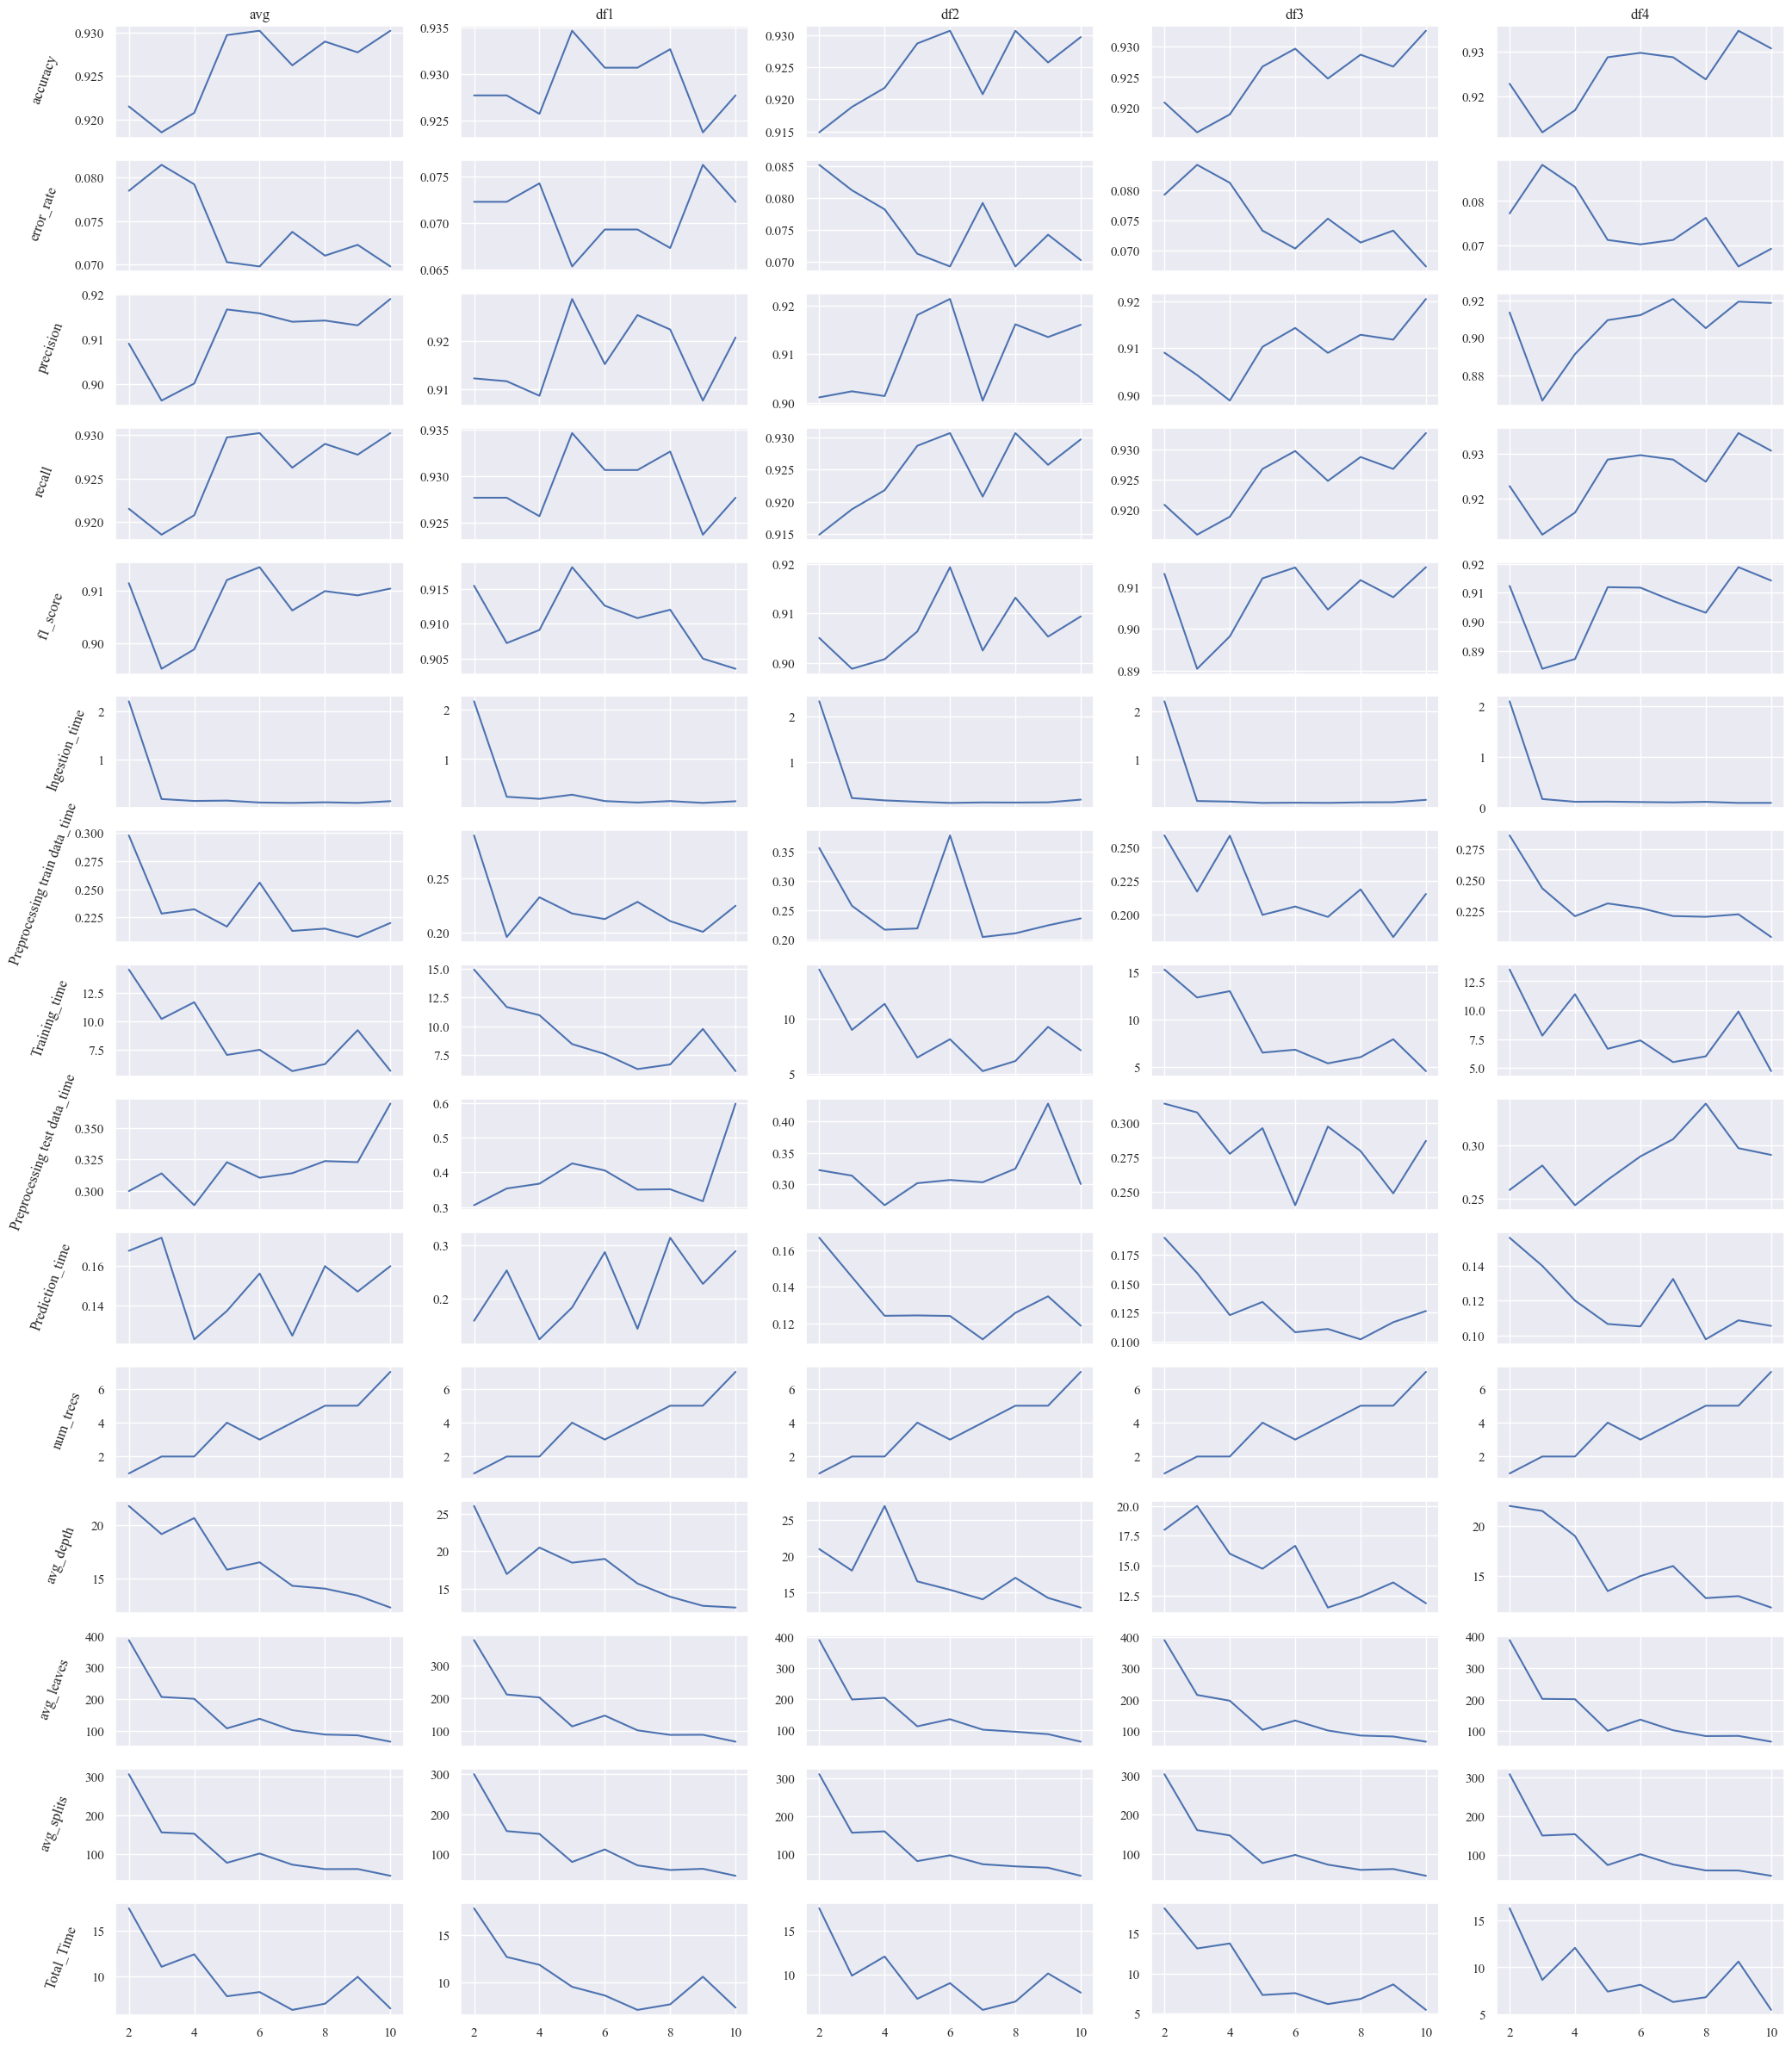

In [127]:
fig, ax = plt.subplots(nrows=len(df_list[0].columns), ncols=len(df_list), sharex=True, figsize=(len(df_list) * 5, len(df1.columns) * 2))

for j, df in enumerate(df_list):
    for i, col in enumerate(df.columns):
        vals = df[col]
        ax[i, j].plot(vals.index, vals.values)
        if j == 0:
            ax[i, j].set_ylabel(col, rotation=70, labelpad=20)
        if i == 0:
            ax[i, j].set_title(f"{df_names[j]}", fontsize=12)

plt.savefig(f'metrics.png', dpi=300, bbox_inches='tight')

## Accuracy vs Partition number

** Could ideally do with balanced accuracy (report indicates this)

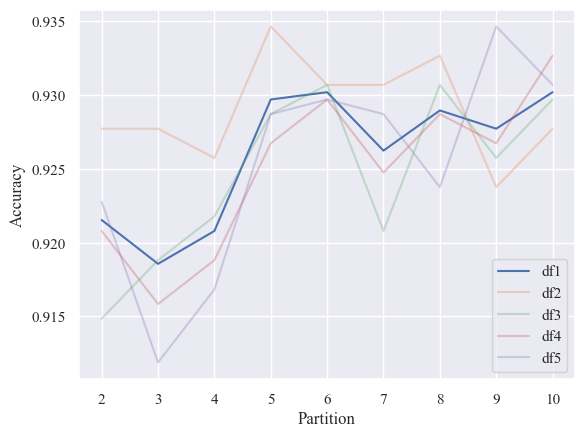

In [128]:
fig, ax = plt.subplots(ncols=1, nrows=1)

for j, df in enumerate(df_list):
    if j == 0:
        ax.plot(df['accuracy'], alpha=1)
    else:
        ax.plot(df['accuracy'], alpha=0.3)
        
ax.set_ylabel(f"Accuracy")
ax.set_xlabel(f"Partition")
ax.legend([f"df{j+1}" for j in range(len(df_list))])

plt.savefig(f'accuracyVSpartition.png', dpi=1200, bbox_inches='tight')

## Runtime vs Partition number

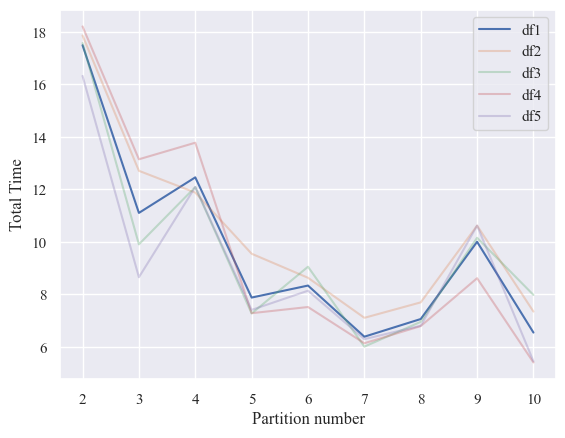

In [129]:
fig, ax = plt.subplots(ncols=1, nrows=1)

for j, df in enumerate(df_list):
    if j == 0:
        ax.plot(df['Total_Time'], alpha=1)
    else:
        ax.plot(df['Total_Time'], alpha=0.3)
ax.set_ylabel(f"Total Time")
ax.set_xlabel(f"Partition number")
ax.legend([f"df{j+1}" for j in range(len(df_list))])

plt.savefig(f'runtimeVSpartition.png', dpi=1200, bbox_inches='tight')

## Accuracy vs Runtime (trade-off)

Consider adding a line of best fit. 

/var/folders/sc/s5l9bfs166l8kkt0npztsmsm0000gn/T/ipykernel_53167/2521860159.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


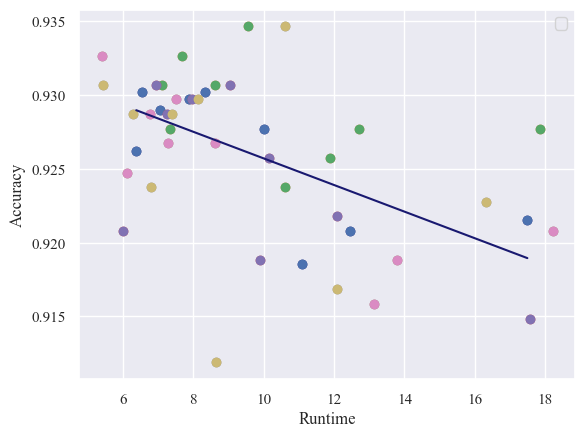

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)

for j, df in enumerate(df_list):
    if j == 0:
        ax.scatter(df['Total_Time'], df['accuracy'], color='midnightblue')
        b, a = np.polyfit(df['Total_Time'], df['accuracy'], 1)
        xseq = np.linspace(df['Total_Time'].min(), df['Total_Time'].max(), 100)
        ax.plot(xseq, b * xseq + a, color='midnightblue')
    else:  
        ax.scatter(df['Total_Time'], df['accuracy'])
    ax.scatter(df['Total_Time'].values, df['accuracy'].values)
ax.set_ylabel(f"Accuracy")
ax.set_xlabel(f"Runtime")

plt.savefig(f'accuracyVSruntime.png', dpi=1200, bbox_inches='tight')

## Speed-up

Need to loop over changing processor number for this. 

In [131]:
Serial_speed = 20 #seconds

def speed_up(Serial_speed, df) -> pd.DataFrame:
    df['Speed_up'] = Serial_speed / df['Total_Time']
    return df

df1 = speed_up(Serial_speed, df1)
df2 = speed_up(Serial_speed, df2)